In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing requirements

In [6]:
!sudo apt install -y tesseract-ocr
!pip install pytesseract transformers datasets seqeval tensorboard evaluate --upgrade


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install -q git+https://github.com/huggingface/transformers.git
# ! pip install -q git+https://github.com/huggingface/datasets.git "dill<0.3.5" seqeval

In [ ]:
# !rm -r layoutlmv3FineTuning
# !git clone -b master https://github.com/UBIAI/layoutlmv3FineTuning.git

rm: cannot remove 'layoutlmv3FineTuning': No such file or directory
Cloning into 'layoutlmv3FineTuning'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 40 (delta 14), reused 40 (delta 14), pack-reused 0
Unpacking objects: 100% (40/40), done.


## Loading UBIAI Annotated dataset from Drive

In [ ]:
#!/bin/bash
IOB_DATA_PATH = "/content/drive/MyDrive/OCR_Sample_PI62DQZ.zip"
! cd /content/
! rm -r data
! mkdir data
! cp "$IOB_DATA_PATH" data/dataset.zip 
! cd data && unzip -q dataset && rm dataset.zip
! cd ..

rm: cannot remove 'data': No such file or directory


## Preprocessing the files for LiLT model

In [ ]:
#!/bin/bash
#preprocessing args
TEST_SIZE = 0.33
DATA_OUTPUT_PATH = "/content/"

In [7]:
%%writefile ./preprocess.py

import pandas as pd
import numpy as np
import os
import argparse
from datasets.features import ClassLabel
from transformers import AutoProcessor
from sklearn.model_selection import train_test_split
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D, Dataset
from datasets import Image as Img
from PIL import Image

import warnings
warnings.filterwarnings('ignore')


def read_text_file(file_path):
    with open(file_path, 'r') as f:
        return (f.readlines())


def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

def get_zip_dir_name():
    try:
        os.chdir('/content/data')
        dir_list = os.listdir()
        zip_dir_name=[]
        for i in dir_list:
            if i[-4:]==".jpg":
                zip_dir_name.append(i)
        if zip_dir_name==[]:
            return False
        return zip_dir_name
    finally:
        os.chdir('./../')


def filter_out_unannotated(example):
    tags = example['ner_tags']
    return not all([tag == label2id['O'] for tag in tags])



if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--valid_size')
    parser.add_argument('--output_path')
    args = parser.parse_args()
    TEST_SIZE = float(args.valid_size)
    OUTPUT_PATH = args.output_path

    os.makedirs(args.output_path, exist_ok=True)
    files = {}
    zip_dir_name = get_zip_dir_name()
    print(zip_dir_name)

    files['train_box'] = read_text_file(os.path.join(os.curdir, 'data', "7519f93a-3468-40b7-b67f-ce4b9ea441d0_box.txt"))
    files['train_image'] = read_text_file(os.path.join(os.curdir, 'data', "7519f93a-3468-40b7-b67f-ce4b9ea441d0_image.txt"))
    files['train'] = read_text_file(os.path.join(os.curdir, 'data', "7519f93a-3468-40b7-b67f-ce4b9ea441d0.txt"))
    
    
    assert(len(files['train']) == len(files['train_box']))
    assert(len(files['train_box']) == len(files['train_image']))
    assert(len(files['train_image']) == len(files['train']))

    images = {}
    for i, row in enumerate(files['train_image']):
        if row != '\n':
            image_name = row.split('\t')[-1]
            images.setdefault(image_name.replace('\n', ''), []).append(i)

    words, bboxes, ner_tags, image_path = [], [], [], []
    i=0
    for image, rows in images.items():
        words.append([row.split('\t')[0].replace('\n', '')
                     for row in files['train'][rows[0]:rows[-1]+1]])
        ner_tags.append([row.split('\t')[1].replace('\n', '')
                        for row in files['train'][rows[0]:rows[-1]+1]])
        bboxes.append([box.split('\t')[1].replace('\n', '')
                      for box in files['train_box'][rows[0]:rows[-1]+1]])
        if zip_dir_name:
            image_path.append(f"/content/data/{zip_dir_name[i]}")
            i+=1
        else:
            image_path.append(f"/content/data/{image}")

    labels = list(set([tag for doc_tag in ner_tags for tag in doc_tag]))
    id2label = {v: k for v, k in enumerate(labels)}
    label2id = {k: v for v, k in enumerate(labels)}

    dataset_dict = {
        'id': range(len(words)),
        'tokens': words,
        'bboxes': [[list(map(int, bbox.split())) for bbox in doc] for doc in bboxes],
        'ner_tags': [[label2id[tag] for tag in ner_tag] for ner_tag in ner_tags],
        'image': [Image.open(path).convert("RGB") for path in image_path]
    }
    print(dataset_dict)

    #raw features
    features = Features({
        'id': Value(dtype='string', id=None),
        'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
        'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
        'ner_tags': Sequence(feature=ClassLabel(num_classes=len(labels), names=labels, names_file=None, id=None), length=-1, id=None),
        'image': Img(decode=True, id=None)
    })

    full_data_set = Dataset.from_dict(dataset_dict, features=features)
    dataset = full_data_set.train_test_split(test_size=0.33)
    processor = AutoProcessor.from_pretrained(
        "microsoft/layoutlmv3-base", apply_ocr=False)

    features = dataset["train"].features
    column_names = dataset["train"].column_names
    image_column_name = "image"
    text_column_name = "tokens"
    boxes_column_name = "bboxes"
    label_column_name = "ner_tags"

    features = Features({
        'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
        'input_ids': Sequence(feature=Value(dtype='int64')),
        'attention_mask': Sequence(Value(dtype='int64')),
        'bbox': Array2D(dtype="int64", shape=(512, 4)),
        'labels': Sequence(ClassLabel(names=labels)),
    })



    train_dataset = dataset["train"].map(
        prepare_examples,
        batched=True,
        remove_columns=column_names,
        features=features,
    )
    eval_dataset = dataset["test"].map(
        prepare_examples,
        batched=True,
        remove_columns=column_names,
        features=features,
    )
    train_dataset.set_format("torch")
    if not OUTPUT_PATH.endswith('/'):
        OUTPUT_PATH += '/'
    train_dataset.save_to_disk(f'{OUTPUT_PATH}train_split')
    eval_dataset.save_to_disk(f'{OUTPUT_PATH}eval_split')
    print(dataset)
    dataset.save_to_disk(f'{OUTPUT_PATH}raw_data')

Writing ./preprocess.py


In [8]:
## Running Preprocessing script
!python3 /content/preprocess.py --valid_size $TEST_SIZE --output_path $DATA_OUTPUT_PATH

['invoice-template-us-oldie_2023-05-02_06:37:01_image_0.jpg', 'sample-invoice-printable_2023-05-02_06:37:01_image_0.jpg']
{'id': range(0, 2), 'tokens': [['Stanford', 'Plumbing', '&', 'Heating', 'INVOICE', '123', 'Madison', 'drive,', 'Seattle,', 'WA,', '7829Q', 'www.plumbingstanford.com', '990-120-4560', 'BILL', 'TO', 'Invoice', 'No:', '#INV02081', 'Allen', 'Smith', 'Invoice', 'Date:', '11/11/18', '87', 'Private', 'st,', 'Seattle,', 'WA', 'Due', 'Date:', '12/01/18', 'allen@gmail.com', '990-302-1898', 'DESCRIPTION', 'QTY/', 'HR', 'UNIT', 'PRICE', 'TOTAL', 'Installed', 'new', 'kitchen', 'sink', '(hours)', '3', '50.00', '150.00', 'Toto', 'sink', '1', '500.00', '500.00', 'Worcester', 'greenstar', 'magnetic', 'system', 'filter', '1', '190.00', '190.00', 'Nest', 'smart', 'thermostat', '1', '250.00', '250.00', 'Worcester', 'Greenstar', '30i', '1', '1500.00', '1500.00', 'SUBTOTAL', '2590.00', 'DISCOUNT', '50.00', 'SUBTOTAL', 'LESS', 'DISCOUNT', '2540.00', 'Tank', 'you', 'for', 'your', 'business

In [9]:
from datasets import load_metric
from transformers import TrainingArguments, Trainer
from transformers import LayoutLMv3ForTokenClassification,AutoProcessor
from transformers.data.data_collator import default_data_collator
import torch

In [10]:
# load datasets
from datasets import load_from_disk
train_dataset = load_from_disk(f'/content/train_split')
eval_dataset = load_from_disk(f'/content/eval_split')


In [11]:
## Loading raw dataset without Encoding or applying feature extractor
train_raw_dataset = load_from_disk(f'/content/raw_data/train')
eval_raw_dataset = load_from_disk(f'/content/raw_data/test')

In [12]:
train_raw_dataset

Dataset({
    features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
    num_rows: 1
})

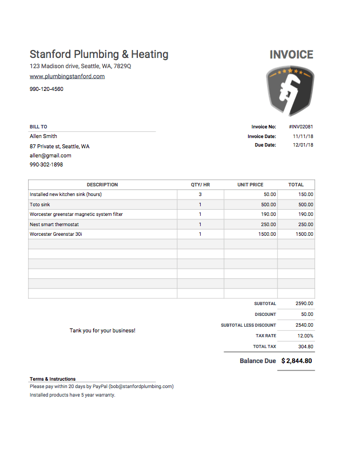

In [13]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/sample-invoice-printable_2023-05-02_06:37:01_image_0.jpg")
image = image.convert("RGB")
image.resize((350,450))


In [14]:
label_list = train_dataset.features["labels"].feature.names
num_labels = len(label_list)
label2id, id2label = dict(), dict()
for i, label in enumerate(label_list):
    label2id[label] = i
    id2label[i] = label

In [15]:
from transformers import LiltForTokenClassification

# huggingface hub model id
model_id = "SCUT-DLVCLab/lilt-roberta-en-base"

# load model with correct number of labels and mapping
model = LiltForTokenClassification.from_pretrained(
    model_id, num_labels=len(label_list), label2id=label2id, id2label=id2label
)


Some weights of LiltForTokenClassification were not initialized from the model checkpoint at SCUT-DLVCLab/lilt-roberta-en-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining metric for evaluation of LiLT model

In [16]:
metric = load_metric("seqeval")
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels,zero_division='0')
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

<ipython-input-16-85fe06d7c113>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


### TRAINING OF LiLT Model

In [17]:
from transformers import Trainer, TrainingArguments
NUM_TRAIN_EPOCHS = 50
PER_DEVICE_TRAIN_BATCH_SIZE = 8 
PER_DEVICE_EVAL_BATCH_SIZE = 8
LEARNING_RATE = 4e-5
training_args = TrainingArguments(output_dir="LiLT_INVOICE",
                                  # max_steps=1500,
                                  num_train_epochs=NUM_TRAIN_EPOCHS,
                                  logging_strategy="epoch",
                                  save_total_limit=1,
                                  per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
                                  per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
                                  learning_rate=LEARNING_RATE,
                                  evaluation_strategy="no",
                                  save_strategy="no",
                                  # eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

35

In [18]:
# Start training
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


TrainOutput(global_step=50, training_loss=0.0, metrics={'train_runtime': 12.3161, 'train_samples_per_second': 4.06, 'train_steps_per_second': 4.06, 'total_flos': 13907430758400.0, 'train_loss': 0.0, 'epoch': 50.0})

### Evaluation Of LiLT Model

In [19]:
trainer.evaluate()


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'eval_loss': 0.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 0.0973,
 'eval_samples_per_second': 10.274,
 'eval_steps_per_second': 10.274,
 'epoch': 50.0}

### Saving Trained Model

In [20]:
trainer.save_model('/content/LiLTmodel/')

### Inference using Fine-Tuned LiLT Model

In [27]:
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from transformers import LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("/content/LiLTmodel")


model_id="SCUT-DLVCLab/lilt-roberta-en-base"

# use LayoutLMv3 processor without ocr since the dataset already includes the ocr text
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=True) # set
tokenizer = AutoTokenizer.from_pretrained(model_id)
# cannot use from_pretrained since the processor is not saved in the base model
processor = LayoutLMv3Processor(feature_extractor, tokenizer)



# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
'I-SELLER' :"blue",
 'S-TTC':"orange",
 'B-DATE_ID':"green",
 'E-DATE_ID':"green",
 'S-MONTANT_HT_ID':"pink",
 'B-DATE':"magenta",
 'I-DATE_ID':"green",
 'I-TVA_ID':"violet",
 'B-SELLER_ID':"blue",
 'I-TTC_ID':"red",
 'S-TTC_ID':"red",
 'E-INVOICE_ID':"yellow",
 'I-SELLER_ID':"blue",
 'S-SELLER_ID':"blue",
 'B-MONTANT_HT':"purple",
 'I-DATE':"magenta",
 'I-MONTANT_HT':"purple",
 'E-TVA_ID':"violet",
 'E-MONTANT_HT':"purple",
 'S-SELLER':"blue",
 'B-INVOICE_ID':"yellow",
 'E-TVA':"brown",
 'E-DATE':"magenta",
 'E-INVOICE_NUMBER':"cyan",
 'E-TTC':"orange",
 'E-MONTANT_HT_ID':"pink",
 'S-INVOICE_NUMBER':"cyan",
 'I-INVOICE_ID':"yellow",
 'B-TTC_ID':"red",
 'B-TVA_ID':"violet",
 'I-TTC':"orange",
 'S-INVOICE_ID':"yellow",
 'I-INVOICE_NUMBER':"cyan",
 'B-TTC':"orange",
 'S-DATE':"magenta",
 'E-TTC_ID':"red",
 'B-INVOICE_NUMBER':"cyan",
 'S-DATE_ID':"green",
 'S-TVA':"brown",
 'E-SELLER':"blue",
 'B-MONTANT_HT_ID':"pink",
 'I-MONTANT_HT_ID':"pink",
 'S-TVA_ID':"violet",
 'O':"green",
 'E-SELLER_ID':"blue",
 'B-SELLER':"red",
 'S-MONTANT_HT':"purple",
 'B-TVA':"brown",
 'o':"green"}

# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels






/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


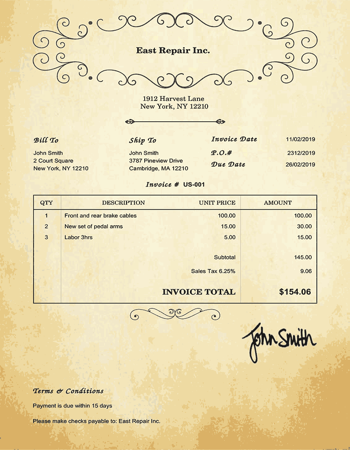

In [29]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/invoice-template-us-oldie_2023-05-02_06:37:01_image_0.jpg")
image = image.convert("RGB")
image.resize((350,450))

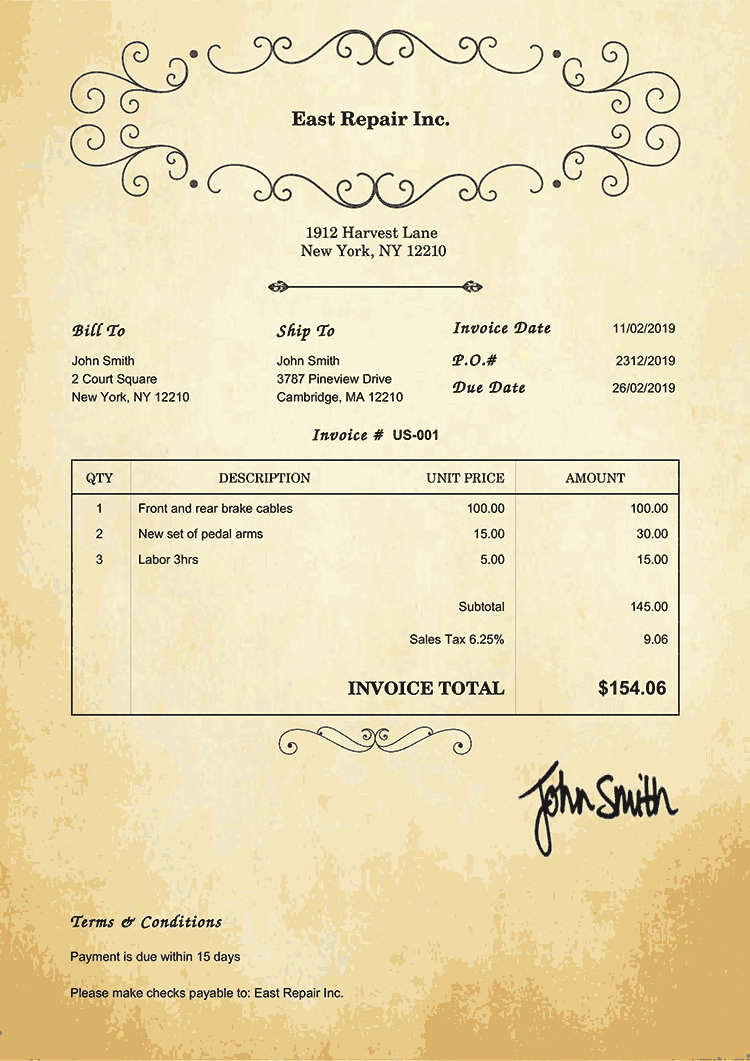

In [30]:
run_inference(image)